In [148]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import SpectralClustering, MeanShift, estimate_bandwidth, AffinityPropagation, KMeans, MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn import metrics
from itertools import cycle

This Notebook contains the unsupervised learning models for the 2014 Boston Marathon data. I will use all five models learned in the previous lessons (K-Means, miniBatchKMeans, Mean-Shift, Spectral Clustering, and Affinity Propagation) to see which one is best suited for the marathon data. I also want to show a few visualizations along with the preprocessing to flesh out the understanding of what is being modeled. 

In [149]:
dfpath = ("https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv")

df = pd.read_csv(dfpath)

### Preprocessing

First, I take a look at the raw data to see what needs to be done to ready it for modeling.

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


The first thing I see is that the times for the various checkpoints (10k - 40k) are objects, not numerics. I'll convert them. Next I see that a few of these features are really not useful for any modeling purposes, like name. Genderdiv is very empty to the point of being useless. That can be removed. A couple of the features (gender and country) are categorica. Of course gender is binary. But the country coumn contains a lot of categorical data as one would expect. 

In [151]:
df.columns

Index(['10k', 'name', 'division', '25k', 'gender', 'age', 'official', 'bib',
       'genderdiv', 'ctz', '35k', 'overall', 'pace', 'state', '30k', '5k',
       'half', '20k', 'country', 'city', '40k'],
      dtype='object')

In [152]:
dfp = pd.get_dummies(data=df, columns=['gender', 'country'])

In [153]:
dfp = dfp.drop(['name', 'bib', 'ctz', 'state', 'city', 'division'], 1)

In [154]:
dfp['5k'] = pd.to_numeric(dfp['5k'], errors='coerce')
dfp['10k'] = pd.to_numeric(dfp['10k'], errors='coerce')
dfp['20k'] = pd.to_numeric(dfp['20k'], errors='coerce')
dfp['25k'] = pd.to_numeric(dfp['25k'], errors='coerce')
dfp['30k'] = pd.to_numeric(dfp['30k'], errors='coerce')
dfp['35k'] = pd.to_numeric(dfp['35k'], errors='coerce')
dfp['40k'] = pd.to_numeric(dfp['40k'], errors='coerce')
dfp['half'] = pd.to_numeric(dfp['half'], errors='coerce')

In [155]:
dfp.head()

,10k,25k,age,official,genderdiv,35k,overall,pace,30k,5k,...,country_TPE,country_TRI,country_TUR,country_UAE,country_UKR,country_URU,country_USA,country_VEN,country_VGB,country_ZIM
0,17.37,47.67,47,85.25,8,71.40,8,3.27,59.18,8.02,...,0,0,0,0,0,0,0,0,0,0
1,32.58,82.43,33,138.95,1,116.37,21,5.30,99.33,16.22,...,0,0,0,0,0,0,0,0,0,0
2,16.62,45.80,41,80.60,1,67.42,1,3.08,56.45,7.75,...,0,0,0,0,0,0,0,0,0,0
3,32.57,82.43,24,140.58,3,116.37,27,5.37,99.33,16.20,...,0,0,0,0,0,0,0,0,0,0
4,17.12,46.37,40,81.23,2,67.83,2,3.10,57.03,8.02,...,0,0,0,0,0,0,0,0,0,0


Now below I can see that the checkpoint time data is ready to be used as a float. 

In [156]:
dfp['30k'].describe()

count    31944.000000
mean       164.571219
std         33.953683
min         56.450000
25%        140.670000
50%        157.730000
75%        182.880000
max        376.380000
Name: 30k, dtype: float64

Below I see that some of the checkpoint data is missing. This makes sense as it is difficult to capture the times of every individual at every point among such a swell of runners. The fact that there isn't more missing data is actually pretty impressive. Certainly no point in fillna. No real benefit to imputation either. There isn't that much missing. So dropping those rows will still leave most of the data intact. 

In [157]:
dfp.isnull().sum().sort_values(ascending=False).head(20)

25k            216
half            72
5k              52
20k             51
10k             50
30k             40
40k             39
35k             34
country_EST      0
country_DOM      0
country_CHI      0
country_CHN      0
country_COL      0
country_CRC      0
country_CRO      0
country_CZE      0
country_DEN      0
country_ECU      0
country_ESP      0
country_EGY      0
dtype: int64

In [158]:
dfp = dfp.dropna()

### Initial Data Analysis

(array([ 580., 1764., 4673., 5737., 5815., 4500., 3148., 2411., 1607.,
         934.,  488.,  327.]),
 array([   0.        ,  230.41666667,  460.83333333,  691.25      ,
         921.66666667, 1152.08333333, 1382.5       , 1612.91666667,
        1843.33333333, 2073.75      , 2304.16666667, 2534.58333333,
        2765.        ]),
 <a list of 12 Patch objects>)

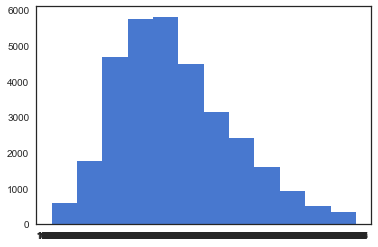

In [159]:
plt.hist(df['10k'], bins=12)

Checking out the distribution of one of the checkpoints. Seems normal. Let's check out the rest. 

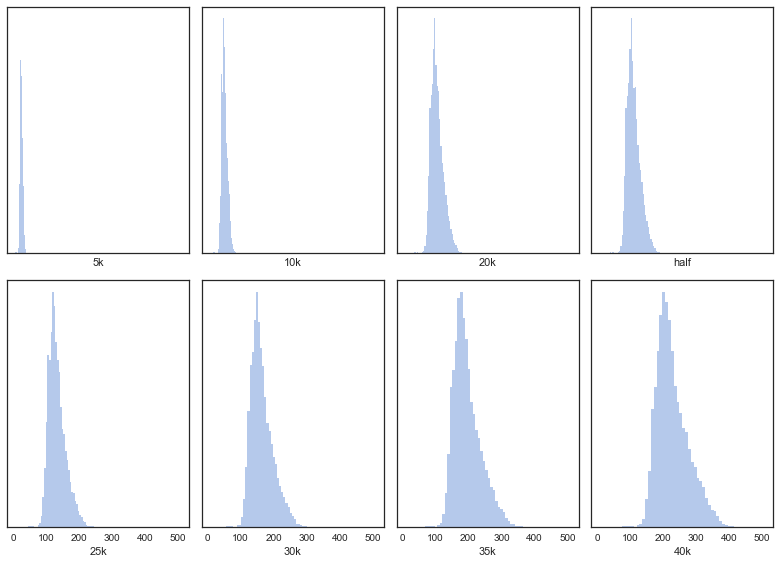

In [160]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2, 4, figsize=(11,8), sharex=True)
sns.distplot(dfp['5k'], kde=False, color="b", ax=axes[0, 0])
sns.distplot(dfp['10k'], kde=False, color="b", ax=axes[0, 1])
sns.distplot(dfp['20k'], kde=False, color="b", ax=axes[0, 2])
sns.distplot(dfp['half'], kde=False, color="b", ax=axes[0, 3])
sns.distplot(dfp['25k'], kde=False, color="b", ax=axes[1, 0])
sns.distplot(dfp['30k'], kde=False, color="b", ax=axes[1, 1])
sns.distplot(dfp['35k'], kde=False, color="b", ax=axes[1, 2])
sns.distplot(dfp['40k'], kde=False, color="b", ax=axes[1, 3])
plt.setp(axes, yticks=[])
plt.tight_layout()

Very normal indeed. A slight skew to the right, but definitely normally distributed. 

In [161]:
df2 = pd.read_csv(dfpath)

I want to check out the quantiles and outliers of the overall pace displayed by gender. But since I had already created dummies for gender, I'll create a new DataFrame for this visualization. 

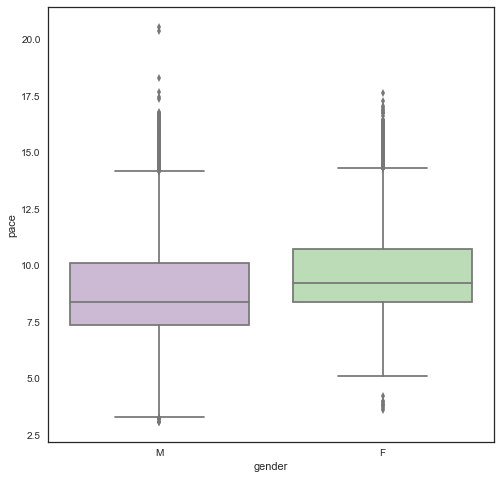

In [162]:
sns.set(style="white", palette="muted", color_codes=True)
plt.figure(figsize=(8,8))
sns.boxplot(y="pace", x="gender", data=df2, palette="PRGn")

The bulk of the women seem to hold a slightly faster pace than the bulk of the men. There are outliers on the top end as would be expected in such a global competitive sport. But look how similar the boxplots are by gender. 

In [163]:
df2['gender'].value_counts()

M    17617
F    14367
Name: gender, dtype: int64

Class imbalance by gender isn't a problem

In [164]:
df['country'].value_counts().head(20)

USA    27233
CAN     2175
GBR      346
ITA      212
MEX      205
GER      182
JPN      175
AUS      124
IRL      119
FRA      115
ESP       89
BRA       87
SWE       66
SUI       62
KOR       60
NED       54
HKG       53
DEN       50
CHN       42
COL       40
Name: country, dtype: int64

North America is, unsurprisingly, the home of most of the participants. But there are still double digits for many countries. I need to consider the consequences of creating dummies for each of these countries and how that will affect the size of my feature space and thus the overall processing time of my models. 

What about the age of the runners? How is that distributed? I'll graph that, split by gender. 

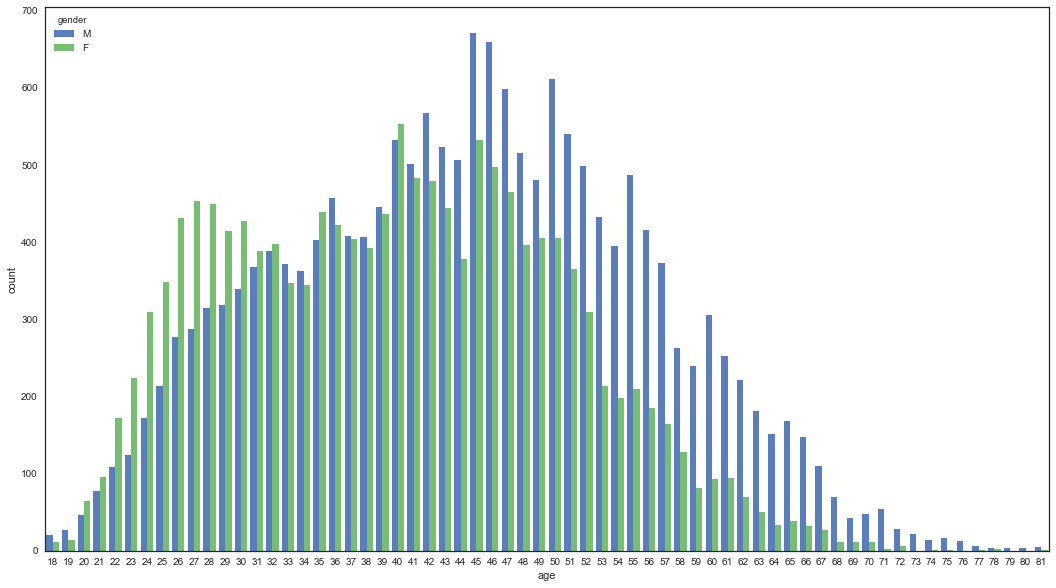

In [165]:
plt.figure(figsize=(18,10))
ax = sns.countplot(x="age", hue="gender", data=df)

Impressively normaly distributed really. I might have expected the majority of the runners to be in their 20s. But it seems that this is an event taken on by older, more seasoned runners. 

Let's go back to the countries. I am concerned about that. How many dummies am I creating and for what percentage of the values?

78 countries, and so many of them with just a single digit number of participants. For the sake of being thorough I want to run my model with them though. I can let PCA do the decomposition. 

Time to run the models. 

The feature that seems to be my obvious target is 'overall' which is the ordinal ranking of finishers. No divisions. No genders. Just a single rank assigned to each runner based on their position at the finish. 

## Unsupervised Models

## NOTE:

#### Below are several cells of Spectral Clustering, Mean-Shift, and Affinity Propagation models as well as models obn the dataset without PCA and including the 'Country' feature which when made into dummies added 92 unnecessary features to the feature space. These cells ahve all been commented out. After attempting to run them across several iterations I have found that K-Means is the best model for clustering this dataset. I will run K-Means and MiniBatchKMeans on it for three different target features (Overall, Age, & Gender). All are run using 2-feature PCA without normalization. 

### K-Means (No PCA)

In [166]:
dfp.shape

(31649, 93)

In [167]:
X = dfp.drop(['overall'], 1)
y = dfp['overall']

In [168]:
# # Calculate predicted values.
# y_pred = KMeans(n_clusters=10).fit_predict(X)
# # Plot the solution.
# # plt.figure().gca(projection='3d')
# plt.scatter(X, y, c=y_pred)
# plt.show()
# # Check the solution against the data.
# print('Comparing k-means clusters against the data:')
# print(pd.crosstab(y_pred, y))

I wanted to find the upper limit of my computational cost. So I ran a K-Means model on the full dataset. I had other things to do with my day so I didn't mind letting it run for a few hours if need be. And indeed it did run and run. Several hours later I had no sign of the model being complete. I think I will run the model again without the dummies for country. That's 78 features gone. Perhaps that will run in a reasonable amount of time. And if not, there is always PCA to reduce my dimensionality to a couple of features that will certainly be able to modeled in a matter of a few minutes. 

### K-Means without the country feature

In [169]:
dfp_noc = df

In [170]:
dfp_noc = pd.get_dummies(data=df, columns=['gender'])

In [171]:
dfp_noc = dfp_noc.drop(['name', 'bib', 'ctz', 'state', 'city', 'division', 'country'], 1)

In [172]:
dfp_noc['5k'] = pd.to_numeric(dfp_noc['5k'], errors='coerce')
dfp_noc['10k'] = pd.to_numeric(dfp_noc['10k'], errors='coerce')
dfp_noc['20k'] = pd.to_numeric(dfp_noc['20k'], errors='coerce')
dfp_noc['25k'] = pd.to_numeric(dfp_noc['25k'], errors='coerce')
dfp_noc['30k'] = pd.to_numeric(dfp_noc['30k'], errors='coerce')
dfp_noc['35k'] = pd.to_numeric(dfp_noc['35k'], errors='coerce')
dfp_noc['40k'] = pd.to_numeric(dfp_noc['40k'], errors='coerce')
dfp_noc['half'] = pd.to_numeric(dfp_noc['half'], errors='coerce')

In [173]:
X = dfp.drop(['overall'], 1)
y = dfp['overall']

In [174]:
# y_pred = KMeans(n_clusters=3).fit_predict(X)
# Plot the solution.
# plt.figure().gca(projection='3d')
# plt.scatter(X, y, c=y_pred)
# plt.show()
# Check the solution against the data.
# print('Comparing k-means clusters against the data:')
# print(pd.crosstab(y_pred, y))

90 minutes later and the model is still running for 5 clusters, even without the country dummies. I'm going to interrupt the kernel and move on to the PCA verion. I may come back to run this again when I have time to walk away and let it run without interrupting the rest of my modeling. 

I will run the PCA model for both normalized and un-normalized data

### K-Means (PCA: 2)

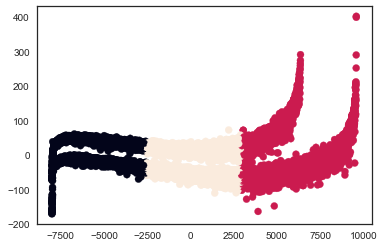

Comparing k-means clusters against the data:
overall  1      2      3      4      5      6      7      8      9      10     \
row_0                                                                           
0            2      2      2      2      2      2      2      2      2      2   
1            0      0      0      0      0      0      0      0      0      0   
2            0      0      0      0      0      0      0      0      0      0   

overall  ...    31903  31906  31907  31909  31917  31925  31926  31929  31930  \
row_0    ...                                                                    
0        ...        0      0      0      0      0      0      0      0      0   
1        ...        1      1      1      1      1      1      1      1      1   
2        ...        0      0      0      0      0      0      0      0      0   

overall  31931  
row_0           
0            0  
1            1  
2            0  

[3 rows x 31596 columns]


In [175]:
# Reduce it to two components.
X_pca = PCA(2).fit_transform(X)
# Calculate predicted values.
y_pred = KMeans(n_clusters=3).fit_predict(X_pca)
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Looking at these two bands of data one might assume that the clusters should follow their top and bottom groupings. Before making this assumption and running this model on the other targets I want to run it again for 5 clusters. 

### K-Means with 5 Clusters

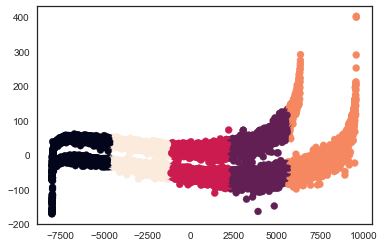

Comparing k-means clusters against the data:
overall  1      2      3      4      5      6      7      8      9      10     \
row_0                                                                           
0            2      2      2      2      2      2      2      2      2      2   
1            0      0      0      0      0      0      0      0      0      0   
2            0      0      0      0      0      0      0      0      0      0   
3            0      0      0      0      0      0      0      0      0      0   
4            0      0      0      0      0      0      0      0      0      0   

overall  ...    31903  31906  31907  31909  31917  31925  31926  31929  31930  \
row_0    ...                                                                    
0        ...        0      0      0      0      0      0      0      0      0   
1        ...        0      0      0      0      0      0      0      0      0   
2        ...        0      0      0      0      0      0      0

In [176]:
y_pred = KMeans(n_clusters=5).fit_predict(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

The five clusters still run horizontal without regard for the visual split that occurs and grows further as the data plots diverge. 

The lesson teaches the value in performing a MiniBatchKMeans as a way to significantly reduce the processing time without a great loss of information, through sampling. 

### Minibatch

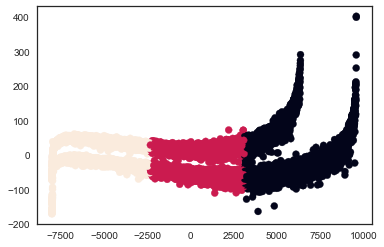

Comparing k-means clusters against the data:
overall  1      2      3      4      5      6      7      8      9      10     \
row_0                                                                           
0            2      2      2      2      2      2      2      2      2      2   
1            0      0      0      0      0      0      0      0      0      0   
2            0      0      0      0      0      0      0      0      0      0   
3            0      0      0      0      0      0      0      0      0      0   
4            0      0      0      0      0      0      0      0      0      0   

overall  ...    31903  31906  31907  31909  31917  31925  31926  31929  31930  \
row_0    ...                                                                    
0        ...        0      0      0      0      0      0      0      0      0   
1        ...        0      0      0      0      0      0      0      0      0   
2        ...        0      0      0      0      0      0      0

In [177]:
minibatch = MiniBatchKMeans(init='random', n_clusters=3, batch_size=200).fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=minibatch)
plt.show()

print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

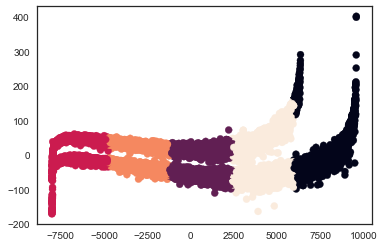

Comparing k-means clusters against the data:
overall  1      2      3      4      5      6      7      8      9      10     \
row_0                                                                           
0            2      2      2      2      2      2      2      2      2      2   
1            0      0      0      0      0      0      0      0      0      0   
2            0      0      0      0      0      0      0      0      0      0   
3            0      0      0      0      0      0      0      0      0      0   
4            0      0      0      0      0      0      0      0      0      0   

overall  ...    31903  31906  31907  31909  31917  31925  31926  31929  31930  \
row_0    ...                                                                    
0        ...        0      0      0      0      0      0      0      0      0   
1        ...        0      0      0      0      0      0      0      0      0   
2        ...        0      0      0      0      0      0      0

In [178]:
minibatch = MiniBatchKMeans(init='random', n_clusters=5, batch_size=200).fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=minibatch)
plt.show()

print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

The results of the MiniBatch were pretty much the same, but faster to run. Still, the K-Means was not slow, processing in a matter of seconds. I'll refrain from using the MiniBatch unless K-Means for the next two targets shows significant computational cost. 

### NOTE: You may disregard the models below and move on to the next target for K-Means

### Mean-Shift

In [179]:
# X = dfp.drop(['overall'], 1)
# y = dfp['overall']

In [180]:
# X_pca = PCA(2).fit_transform(X)

In [181]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X_pca,
#     y,
#     test_size=0.7,
#     random_state=42)

In [182]:
# bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
# ms.fit(X_train)

# labels = ms.labels_

# cluster_centers = ms.cluster_centers_

# n_clusters_ = len(np.unique(labels))

# print("Number of estimated clusters: {}".format(n_clusters_))

In [183]:
# plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
# plt.show()

# print('Comparing the assigned categories to the ones in the data:')
# print(pd.crosstab(y_train,labels))

# dfp['cluster'] = pd.crosstab(y_train, labels)
# #cluster becomes the hue for charting

### Spectral Clustering

I will perform a simple Spectral Custering model for three clusters on a train, test split of 70% of the total data. Note from above that test train split is done on the PCA data, reducing the features to 2. This should make it easuer to run the model, computationally. 

### NOTE: it has been over six hours and the model is still fitting. I have to  interrupt and move on.

In [184]:
# n_clusters=3

# sc1 = SpectralClustering(n_clusters=n_clusters)
# sc1.fit(X_train)

# predict=sc1.fit_predict(X_train)

In [185]:
# plt.scatter(X_train[:, 0], X_train1[:, ], c=predict)
# plt.show()

# print('Comparing the assigned categories to the ones in the data:')
# print(pd.crosstab(y_train,predict))

### Affinity Propagation

Affinity Propagation is known for being good with large feature spaces. So I want to run this model once on the the total X, y data to see how it handles it. If that proves too great I'll run it again on the PCA'd train, test split data. 

In [186]:
# af1 = AffinityPropagation().fit(X_train)

# # Pull the number of clusters and cluster assignments for each data point.
# cluster_centers_indices = af1.cluster_centers_indices_
# n_clusters_ = len(cluster_centers_indices)
# labels = af1.labels_

# print('Estimated number of clusters: {}'.format(n_clusters_))

Oof that's a lot of clusters. Should be quite the Pollock to view. This took about 15 minutes to run so it's not inconcievable that I can tune the hyperparameters some to see if I can whittle the clusters down. 

In [187]:
# plt.figure(1)
# plt.clf()

# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(n_clusters_), colors):
#     class_members = labels == k
#     cluster_center = X_train[cluster_centers_indices[k]]
#     plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
#     plt.plot(cluster_center[0],
#              cluster_center[1],
#              'o',
#              markerfacecolor=col,
#              markeredgecolor='k')
#     for x in X_train[class_members]:
#         plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

# plt.title('Estimated number of clusters: {}'.format(n_clusters_))
# plt.show()

### Affinity Propagation (Tuned)

In [188]:
# af = AffinityPropagation(damping=0.5, 
#                           max_iter=200, 
#                           convergence_iter=15, 
#                           preference=None, 
#                           affinity='euclidean', 
#                           verbose=False).fit(X_train)

# # Pull the number of clusters and cluster assignments for each data point.
# cluster_centers_indices = af1.cluster_centers_indices_
# n_clusters_ = len(cluster_centers_indices)
# labels = af1.labels_

# print('Estimated number of clusters: {}'.format(n_clusters_))

# Default parameters are as follows:

# (damping=0.5, max_iter=200, convergence_iter=15, copy=True, preference=None, affinity=’euclidean’, verbose=False)

### Tuning Results

- Damping: 0.5 to 0.8 - No effect
- Damping: 0.5 to 1.0 - took too long and errored out, needs to be below 1.0
- Damping: 0.5 to 0.99, max_iter: 200 to 50 - No effect
- Max-iter: 200 to 50 & 100 - memory error??? Got a MemoryError even after returning to defaults!
- Affinity: euclidean to precomputed - error (S must be a square array, which mine is clearly not [9494,2])

## K-Means (Target = Age)

In [189]:
X = dfp.drop(['age'], 1)
y = dfp['age']

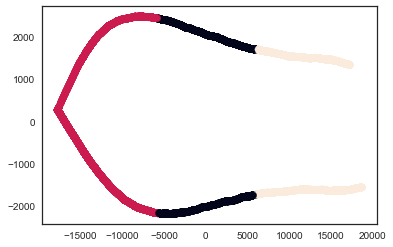

Comparing k-means clusters against the data:
age    18  19  20  21   22   23   24   25   26   27 ...  72  73  74  75  76  \
row_0                                               ...                       
0       9  12  28  45   66   88  117  133  149  164 ...   2   2   1   3   2   
1       8  10  35  63  113  155  209  240  321  328 ...   0   1   0   0   0   
2      16  19  48  63   96  103  153  182  232  241 ...  29  19  12  14  11   

age    77  78  79  80  81  
row_0                      
0       2   0   0   0   1  
1       0   0   0   0   0  
2       4   5   3   3   4  

[3 rows x 64 columns]


In [190]:
X_pca = PCA(2).fit_transform(X)

y_pred = KMeans(n_clusters=3).fit_predict(X_pca)
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

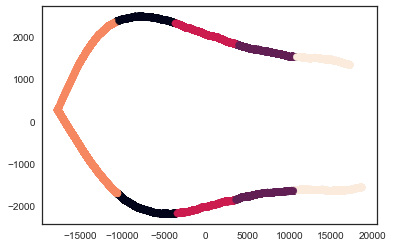

Comparing k-means clusters against the data:
age    18  19  20  21  22  23   24   25   26   27 ...  72  73  74  75  76  77  \
row_0                                             ...                           
0       4   5  22  33  63  84   96  106  136  157 ...   0   1   0   0   0   0   
1       9   9  23  37  45  48   85   88  102  118 ...  10   5   4   7   2   1   
2       5   5  15  20  41  53   62   78   89   98 ...   1   2   0   1   2   1   
3       5   9  22  42  63  95  140  168  218  206 ...   0   0   0   0   0   0   
4      10  13  29  39  63  66   96  115  157  154 ...  20  14   9   9   9   4   

age    78  79  80  81  
row_0                  
0       0   0   0   0  
1       1   0   0   0  
2       0   0   0   1  
3       0   0   0   0  
4       4   3   3   4  

[5 rows x 64 columns]


In [191]:
X_pca = PCA(2).fit_transform(X)

y_pred = KMeans(n_clusters=5).fit_predict(X_pca)
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

At first glance I really don't like all this overlap from one cluster into another. Perhaps adding clusters, one for each age will help. 

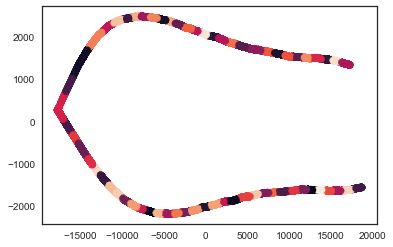

Comparing k-means clusters against the data:
age    18  19  20  21  22  23  24  25  26  27 ...  72  73  74  75  76  77  78  \
row_0                                         ...                               
0       2   2   1   4   4   1   4   5   5   8 ...   0   0   0   1   1   1   0   
1       1   0   1   2   0   2   3   3   3   6 ...   0   1   0   0   0   0   0   
2       2   0   1   1   1   0   2   1   9   4 ...   1   0   1   0   0   0   0   
3       0   0   0   2   4   9  14  14  17  14 ...   0   0   0   0   0   0   0   
4       0   1   4   6   4   4  16  12  12  15 ...   0   0   0   0   0   0   0   
5       1   2   1   6   8   9  11  11  13  10 ...   0   0   0   0   0   0   0   
6       0   0   0   0   1   4   3   3   4   2 ...   0   0   0   0   0   0   0   
7       1   0   1   2   6   5   7   9   6   9 ...   0   0   0   0   0   0   0   
8       1   0   3   3   8   3   9   7  16  12 ...   2   0   0   0   0   0   0   
9       0   1   1   5   2   4   1   7   4  10 ...   0   0   0   

In [192]:
X_pca = PCA(2).fit_transform(X)

y_pred = KMeans(n_clusters=64).fit_predict(X_pca)
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

This didn't help. Instead of something resembling a clear cluster for each age I see clusters spread across the ages. 

## K-Means Target = Gender

In [193]:
dfg = df
dfg = pd.get_dummies(data=df, columns=['gender'])

In [194]:
dfg['5k'] = pd.to_numeric(dfg['5k'], errors='coerce')
dfg['10k'] = pd.to_numeric(dfg['10k'], errors='coerce')
dfg['20k'] = pd.to_numeric(dfg['20k'], errors='coerce')
dfg['25k'] = pd.to_numeric(dfg['25k'], errors='coerce')
dfg['30k'] = pd.to_numeric(dfg['30k'], errors='coerce')
dfg['35k'] = pd.to_numeric(dfg['35k'], errors='coerce')
dfg['40k'] = pd.to_numeric(dfg['40k'], errors='coerce')
dfg['half'] = pd.to_numeric(dfg['half'], errors='coerce')

In [195]:
dfg = dfg.drop(['name', 'bib', 'ctz', 'state', 'city', 'division', 'country', 'gender_F'], 1)

In [196]:
dfg = dfg.dropna()

In [197]:
X = dfg.drop(['gender_M'], 1)
y = dfg['gender_M']

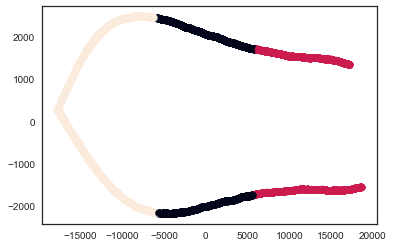

Comparing k-means clusters against the data:
gender_M     0     1
row_0               
0         5809  4661
1         5128  5362
2         3228  7461


In [198]:
X_pca = PCA(2).fit_transform(X)

y_pred = KMeans(n_clusters=3).fit_predict(X_pca)
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

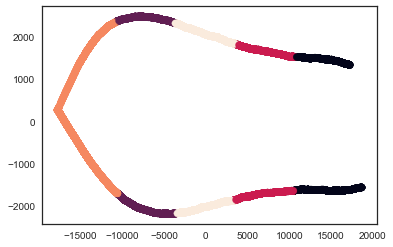

Comparing k-means clusters against the data:
gender_M     0     1
row_0               
0         2888  3383
1         3090  3462
2         3409  2909
3         1213  4960
4         3565  2770


In [199]:
X_pca = PCA(2).fit_transform(X)

y_pred = KMeans(n_clusters=5).fit_predict(X_pca)
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Look at how the models are virtually identical for age and gender. I still notice that like the clustering for Overall the clusters seem to follow a horizontal path instead of breaking off at the point to cluster around each limb. 

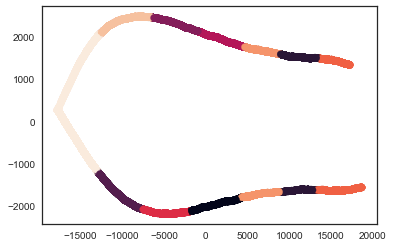

Comparing k-means clusters against the data:
gender_M     0     1
row_0               
0            0  2353
1         2083  1832
2            0  3083
3         2713     0
4         2706     0
5            0  2595
6         1633  2224
7         2044  1920
8         2358     0
9          628  3477


In [200]:
X_pca = PCA(2).fit_transform(X)

y_pred = KMeans(n_clusters=10).fit_predict(X_pca)
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

By increasing my number of cluster it seems I was able to break the limb clusters free of each other. 

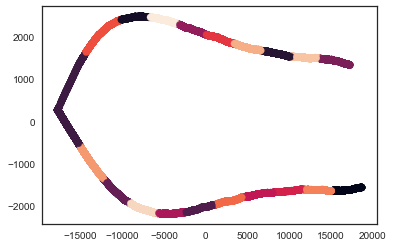

Comparing k-means clusters against the data:
gender_M     0     1
row_0               
0            0  1442
1         1487     0
2         1608     0
3          271  1986
4            0  1393
5            0  1821
6         1603     0
7         1674     0
8            0  1499
9            0  1421
10           0  1430
11        1632     0
12        1114     0
13           0  1388
14           0  1532
15           0  1932
16        1614     0
17        1530     0
18           0  1640
19        1632     0


In [201]:
X_pca = PCA(2).fit_transform(X)

y_pred = KMeans(n_clusters=20).fit_predict(X_pca)
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

By increasing the clusters to 20 I have separated them almost completely. This is the crosstab I'll incorporate back into the dataframe.

In [204]:
labels = KMeans.labels_  # access your kmeans model's labels 
df['clusters'] = labels  # assign the labels back to original dataframe

AttributeError: type object 'KMeans' has no attribute 'labels'

In [ ]:
#Creating cluster feature for use as hue. 
#Will this need concatenation? 
# dfp['cluster'] = pd.crosstab(y_train, labels)

In [ ]:
# plt.figure(figsize=(18,10))
# ax = sns.countplot(x="age", hue="gender", data=df)

## Conclusion

By far the biggest obstacle to this challenge was in the processing time of my models. I would much preferred to not have to use PCA and see how these unsupervised models worked with the whole data. Yes, I'm doing all of this on a laptop that is limited in its processing power. A powerful hardware configuration would be better suited to the task. But I am still dismayed by the obstacle of time here, knowing that as a data scientist I will be working with datasets that contain tens of thousands of features and millions of rows as regular practice. The practice of trial and error with model hyperparameters hits a very big wall when every model takes hours to process. 

However, it was encouraging to see how the reduction of features being clustered on decreased processing time. Age has only 64 values. Gender only 2. But the Overall target has as many values as there are observations in the data. 

So now it comes to the process of taking the crosstab data and reintegrating it into my DataFrame so I can extract useful knowledge that could be reported. 